# Step 1: Convert to 6 x 6 km binary raster

In [3]:
import rasterio
import numpy as np
ds = rasterio.open('esa_asia.tif')
band1 = ds.read(1)

In [4]:
band1.shape

(34200, 46404)

In [5]:
band1 = band1[:, :46400]
band1[band1 == 210] = 0. 

band1 = np.reshape(band1, ((34200 // 20, 20, 46400 // 20, 20)))
band1 = np.sum(band1, axis = (1, 3))
band1 = band1.astype(np.uint16)

In [8]:
band1[band1 > 0] = 1.

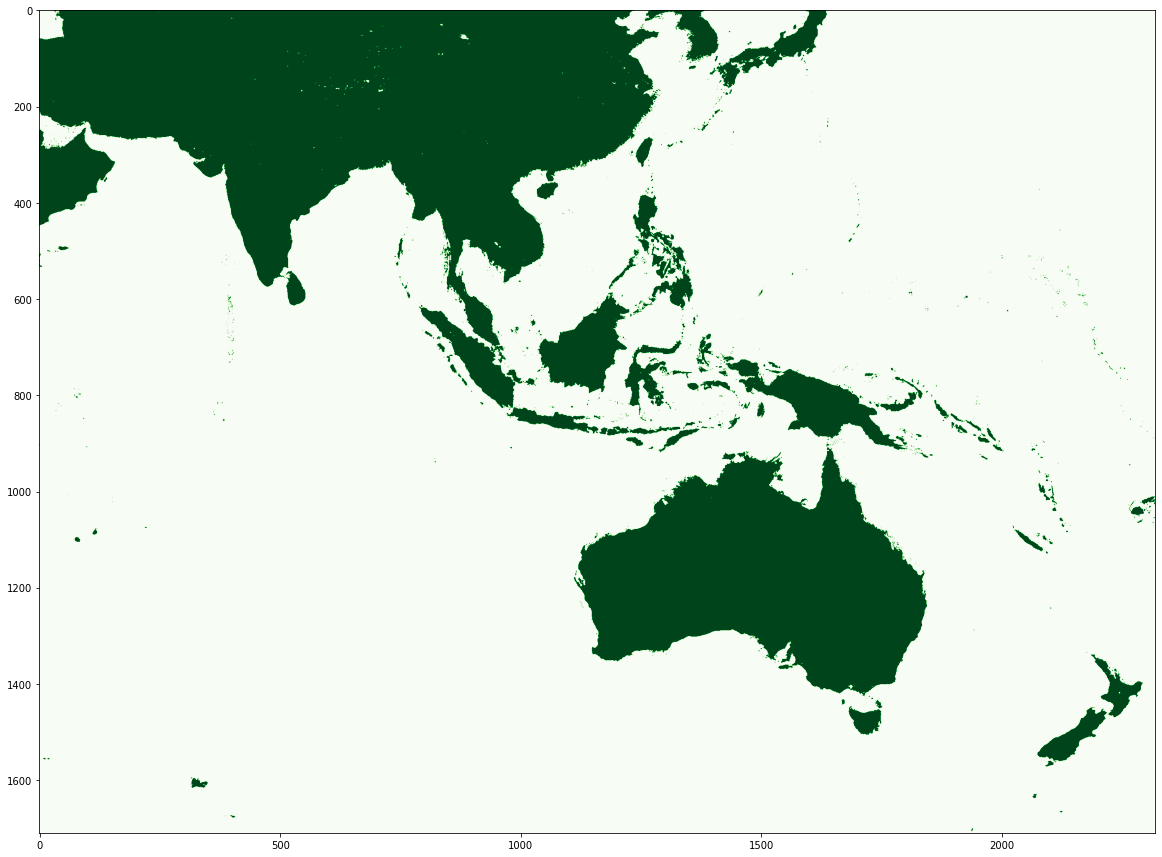

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,17))
plt.imshow(band1, cmap='Greens', vmin=0, vmax=1)
plt.show()

In [10]:
print(f"The total TOF area is: {np.sum(band1) * ((300*300) / (1000*1000))}")

The total TOF area is: 75110.84999999999


In [13]:
import rasterio

transform = rasterio.transform.from_bounds(west = 51.10, south = -55.0,
                                           east = 180., north = 40.,
                                           width = band1.shape[1], 
                                           height = band1.shape[0])

new_dataset = rasterio.open("asia_6km.tif", 'w', driver = 'GTiff',
                           height = band1.shape[0], width = band1.shape[1], count = 1,
                           dtype = 'uint16',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(band1, 1)
new_dataset.close()

In [17]:
import pandas as pd
db = pd.read_csv("asia_grid.csv")
db = db.drop(['VALUE', 'Unnamed: 3'], axis = 1)
db.head(5)

min_tile_id = 5000

,Y,X
0,39.972222,52.794591
1,39.972222,52.850151
2,39.972222,52.905711
3,39.972222,52.961272
4,39.972222,53.016832


In [33]:
db['Y'] = np.around(db['Y'], 4)
db['X'] = np.around(db['X'], 4)

all_y = sorted(np.unique(db['Y']))
all_x = sorted(np.unique(db['X']))

In [ ]:
def id_tile_num(x, y, all_x, all_y, min_x):
    x_id = rank_x[all_x == x]
    y_id = rank_y[all_y == y]
    return x_id + min_x, y_id

db['Y_tile'] = np.nan
db['X_tile'] = np.nan

for index, row in db.iterrows():
    if index % 1000 == 0:
        print(index)
    x, y = id_tile_num(row['X'], row['Y'], all_x, all_y, 5000)
    db['X_tile'][index] = x
    db['Y_tile'][index] = y
    
db.head(20)

In [45]:
db.to_csv("asia_processing_area.csv", index = False)